# Artificial Intelligence: Assignment 2

## Objective: Implementation of Particle Swarm Optimization for feature subset selection

### Importing the required libraries

In [11]:
import time
start = time.time()
import pandas as pd
import numpy as np
from numpy import random
from numpy.core.umath_tests import inner1d
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,cohen_kappa_score,classification_report
np.random.seed(41)

### Defining different Fitness Functions

In [2]:
def fitness1(particle, classifier, x_id):
	tp = []
	for i in range(len(x_id[particle])):
		if x_id[particle][i] > 0.5: tp.append(i)
	X_selected_features = X[:, tp]
	X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size = 0.20, random_state = 0)
	classifier.fit(X_train, y_train)
	y_pred = classifier.predict(X_test)
	fitness = accuracy_score(y_test, y_pred)
	return fitness

In [3]:
def fitness2(particle, classifier, x_id):
	tp = []
	for i in range(len(x_id[particle])):
		if x_id[particle][i] > 0.5: tp.append(i)
	X_selected_features = X[:, tp]
	X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size = 0.20, random_state = 0)
	classifier.fit(X_train, y_train)
	y_pred = classifier.predict(X_test)
	P = accuracy_score(y_test, y_pred)
	alpha = 0.1
	nf = len(tp)
	nt = len(X[0])
	fitness = alpha * P + (1 - alpha) * (1 - nf / nt)
	return fitness

In [4]:
def fitness3(particle, classifier, x_id):
	tp = []
	for i in range(len(x_id[particle])):
		if x_id[particle][i] > 0.5: tp.append(i)
	X_selected_features = X[:, tp]
	X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size = 0.20, random_state = 0)
	classifier.fit(X_train, y_train)
	y_pred = classifier.predict(X_test)
	P = cohen_kappa_score(y_pred,y_test)
	alpha = 0.1
	nf = len(tp)
	nt = len(X[0])
	fitness = alpha * P + (1 - alpha) * (1 - nf / nt)
	return fitness

### Defining PSO function to return feature subset

In [5]:
def PSO(num_particles, num_iter, w, c1, c2, clf, ff):
	plt.figure(figsize=(8,8))
	x_id, v_id, p_id, p_best = [], [], [], []
	for i in range(num_particles):
		tmp = []
		tmp2 = []
		tmp3 = []
		for d in range(dimensions):
			if d < dimensions - 35:
				tmp.append(random.rand() / 10)
				tmp2.append(random.rand())
			else:
				tmp.append(random.rand())
				tmp2.append(random.rand())
			tmp3.append(0)
		x_id.append(tmp)
		v_id.append(tmp3)
		p_id.append(tmp2)
		p_best.append(0)

	if clf == "NN": classifier = classifier1
	elif clf == 'RF': classifier = classifier2
	elif clf == 'SVM': classifier = classifier3
	elif clf == 'DTC': classifier = classifier4
	else: print("Please enter a valid classifier"), exit(0)

	l = []
	for i in range(num_particles): l.append([])
	acc, ite = [], []
	dec = (w - 0.2) / (num_iter - 1)
	k = 1
	while k <= num_iter:
		for particle in range(num_particles):
			if ff == 1: fitness = fitness1(particle, classifier, x_id)
			elif ff == 2: fitness = fitness2(particle, classifier, x_id)
			elif ff == 3: fitness = fitness3(particle, classifier, x_id)
			else: print('Please enter a valid fitness value'), exit(0)
			if fitness > p_best[particle]: 
				p_best[particle] = fitness
				for i in range(len(x_id[particle])):
					p_id[particle][i] = x_id[particle][i]
			l[particle].append(p_best[particle])
		g_best = 0
		for particle in range(num_particles):
			if p_best[particle] > g_best:
				g_best = p_best[particle]
				g_d = []
				for i in range(len(p_id[particle])): g_d.append(p_id[particle][i])
		for i in range(num_particles):
			for d in range(dimensions):
				r1 = random.rand()
				r2 = random.rand()
				v_id[i][d] = w * v_id[i][d] + c1 * r1 * (p_id[i][d] - x_id[i][d]) + c2 * r2 * (g_d[d] - x_id[i][d])
				x_id[i][d] = x_id[i][d] + v_id[i][d]
		w = w - dec
		k = k + 1
		acc.append(g_best)
		ite.append(k)

	for i in range(num_particles): plt.plot(l[i], label = "Particle" + str(i + 1))
	plt.xlabel('Iterations')
	plt.ylabel('Fitness')
	plt.title('Fitness vs Iterations for different particles')
	plt.legend()
	plt.show()	

	plt.xlabel('Iterations')
	plt.ylabel('Global Fitness')
	plt.title('Fitness vs Iterations')
	plt.plot(ite, acc)
	plt.show()
    
	return g_d

### Defining function for printing confusion matrix

In [6]:
def print_confusion_matrix(cm):
  plt.figure(figsize=(5,5))
  plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
  plt.title('Confusion matrix', size = 15)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, ["0", "1"], rotation=45, size = 2)
  plt.yticks(tick_marks, ["0", "1"], size = 2)
  plt.tight_layout()
  plt.ylabel('Actual label', size = 15)
  plt.xlabel('Predicted label', size = 15)
  width, height = cm.shape
  for x in range(width):
   for y in range(height):
    plt.annotate(str(cm[x][y]), xy=(y, x), 
    horizontalalignment='center',
    verticalalignment='center')
  plt.tight_layout()
  plt.show()

### Defining function to test the model with the images of team members and friends

In [9]:
def test(g_d, clf):
	if clf == "NN": classifier = classifier1
	elif clf == 'RF': classifier = classifier2
	elif clf == 'SVM': classifier = classifier3
	elif clf == 'DTC': classifier = classifier4
	else: print("Please enter a valid classifier"), exit(0)
	tp = []
	for i in range(len(g_d)):
		if g_d[i] > 0.5: tp.append(i)
            
	print("Num of features in subset = ", len(tp))

	X_selected_features = X[:, tp]
	classifier.fit(X_selected_features, y)

	test_data = pd.read_csv('Test.csv')
	col_names = list(test_data.columns.values)
	dimensions = len(col_names) - 1
	y_test = test_data.iloc[:, dimensions].values
	X_test = test_data.iloc[:, :dimensions].values
	X_test_selected_features = X_test[:, tp]
	y_test_pred = classifier.predict(X_test_selected_features)
	cm = confusion_matrix(y_test, y_test_pred)
	print_confusion_matrix(cm)
	print(classification_report(y_test, y_test_pred))
	kappa = cohen_kappa_score(y_test_pred,y_test)
	print("kappa = ", kappa)
	print("Accuracy Test = ", accuracy_score(y_test, y_test_pred))

### Loading the ck+ data and running the model

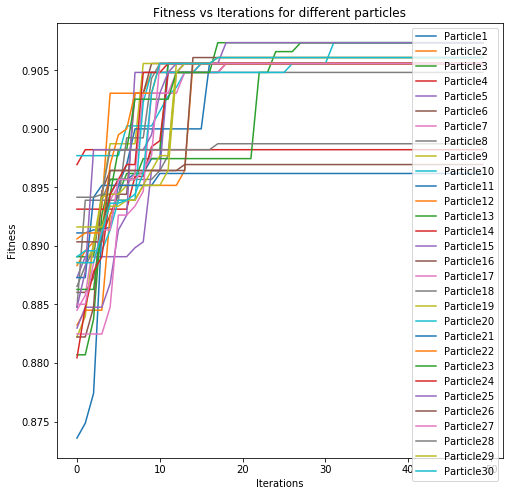

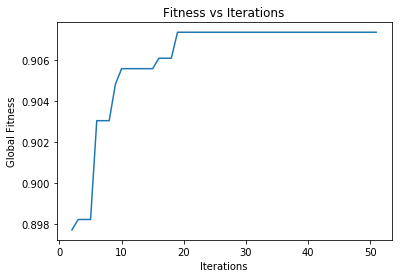

Num of features in subset =  9


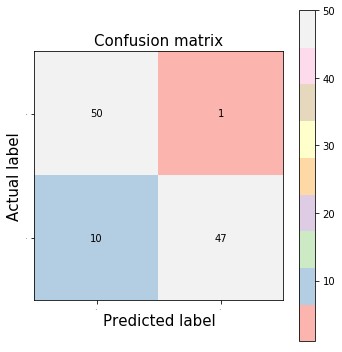

             precision    recall  f1-score   support

          0       0.83      0.98      0.90        51
          1       0.98      0.82      0.90        57

avg / total       0.91      0.90      0.90       108

kappa =  0.7975460122699387
Accuracy Test =  0.8981481481481481
Execution time in minutes =  23.991696540514628


In [12]:
np.random.seed(41)
classifier1 = MLPClassifier(solver='lbfgs', alpha = 1e-5, hidden_layer_sizes=(5, 2), random_state = 1)
classifier2 = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
classifier3 = SVC(kernel = 'rbf',random_state = 0)
classifier4 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

data = pd.read_csv('data.csv')
col_names = list(data.columns.values)
dimensions = len(col_names) - 1
y = data.iloc[:, dimensions].values
X = data.iloc[:, :dimensions].values
cl = 'SVM'
feature_subset = PSO(30, 50, 0.5, 0.5, 0.5, cl, 2)
test(feature_subset, cl)

print("Execution time in minutes = ", (time.time() - start) / 60)